# Cloud Pak for Data Virtualization Demonstration
This notebook will connect to a CP4D cluster and demonstrate how SQL can be run against a variety of data sources without requiring any knowledge of how these data sources are accessed.

The first step is to load the Db2 extensions that allow us to run Db2 commands directly against CP4D.

In [1]:
%run db2.ipynb

Db2 Extensions Loaded.


A connection to the database is required before we can run any SQL statements. Run the following statement to connect to the Cloud Pak for Data cluster. **Note:** If you need to change the connection information, edit the Connection document which is found in the table of contents.

In [2]:
%run connection.ipynb

Db2 Extensions Loaded.
Connection successful.


## Stock Symbol Table
### Get information about the stocks that are in the database
**System Z - VSAM**

In [3]:
%sql -grid select * from DVDEMO.STOCK_SYMBOLS

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

## Stock History Table
### Get Price of a Stock over the Year
Set the Stock Symbol in the line below.

**CP4D - Db2, Skytap -  Informix**

In [4]:
stock = 'INTC'

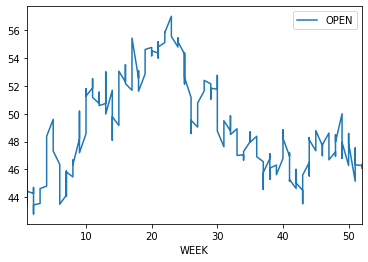

In [5]:
%%sql -pl
SELECT WEEK(TX_DATE) AS WEEK, OPEN FROM FOLDING.STOCK_HISTORY
WHERE SYMBOL = :stock AND TX_DATE != '2017-12-01'
ORDER BY WEEK(TX_DATE) ASC

### Trend of Three Stocks
This chart shows three stock prices over the course of a year.

**CP4D - Db2, Skytap -  Informix**

In [6]:
stocks = ['INTC','MSFT','AAPL']

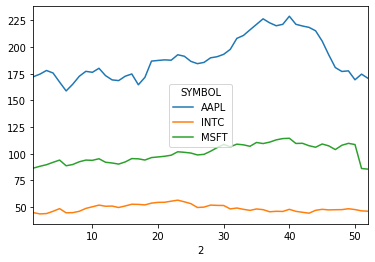

In [7]:
%%sql -pl
SELECT SYMBOL, WEEK(TX_DATE), OPEN FROM FOLDING.STOCK_HISTORY
WHERE SYMBOL IN (:stocks) AND TX_DATE != '2017-12-01'
ORDER BY WEEK(TX_DATE) ASC

### 30 Day Moving Average of a Stock
Enter the Stock Symbol below.

**CP4D - Db2, Skytap -  Informix**

In [8]:
stock = 'AAPL'

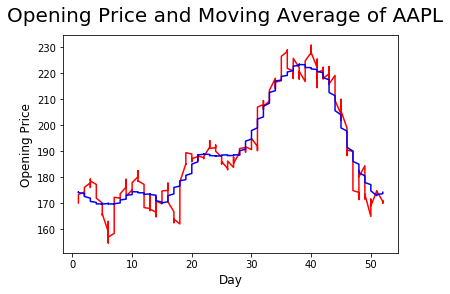

In [9]:
sqlin = \
"""
SELECT WEEK(TX_DATE) AS WEEK, OPEN, 
     AVG(OPEN) OVER (
       ORDER BY TX_DATE
     ROWS BETWEEN 15 PRECEDING AND 15 FOLLOWING) AS MOVING_AVG
  FROM FOLDING.STOCK_HISTORY
     WHERE SYMBOL = :stock
  ORDER BY WEEK(TX_DATE)
"""
df = %sql {sqlin}
txdate= df['WEEK']
sales = df['OPEN']
avg = df['MOVING_AVG']

plt.xlabel("Day", fontsize=12);
plt.ylabel("Opening Price", fontsize=12);
plt.suptitle("Opening Price and Moving Average of " + stock, fontsize=20);
plt.plot(txdate, sales, 'r');
plt.plot(txdate, avg, 'b');
plt.show();

### Trading volume of INTC versus MSFT and AAPL in first week of November
**CP4D - Db2, Skytap -  Informix**

In [10]:
stocks = ['INTC','MSFT','AAPL']

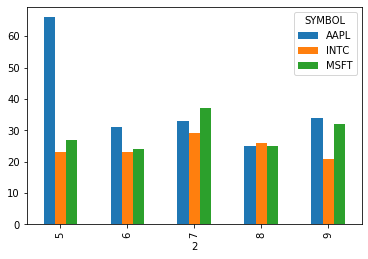

In [11]:
%%sql -pb
SELECT SYMBOL, DAY(TX_DATE), VOLUME/1000000 FROM FOLDING.STOCK_HISTORY
WHERE SYMBOL IN (:stocks) AND WEEK(TX_DATE) =  45
ORDER BY DAY(TX_DATE) ASC

### Show Stocks that Represent at least 3% of the Total Purchases during Week 45
**CP4D - Db2, Skytap -  Informix**

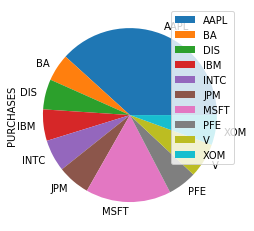

In [12]:
%%sql -pie
WITH WEEK45(SYMBOL, PURCHASES) AS (
  SELECT SYMBOL, SUM(VOLUME * CLOSE) FROM FOLDING.STOCK_HISTORY
    WHERE WEEK(TX_DATE) =  45 AND SYMBOL <> 'DJIA'
  GROUP BY SYMBOL
),
ALL45(TOTAL) AS (
  SELECT SUM(PURCHASES) * .03 FROM WEEK45
)
SELECT SYMBOL, PURCHASES FROM WEEK45, ALL45
WHERE PURCHASES > TOTAL
ORDER BY SYMBOL, PURCHASES

## Stock Transaction Table
### Show Transactions by Customer
**AWS - Db2, Azure - EDB (Postgres), Azure - Db2**

In [13]:
%%sql
SELECT * FROM FOLDING.STOCK_TRANSACTIONS
  WHERE CUSTID = 100000

Command completed.


### Bought/Sold Amounts of Top 5 stocks 
**AWS - Db2, Azure - EDB (Postgres), Azure - Db2**

In [14]:
%%sql
WITH BOUGHT(SYMBOL, AMOUNT) AS
  (
  SELECT SYMBOL, SUM(QUANTITY) FROM FOLDING.STOCK_TRANSACTIONS
  WHERE QUANTITY > 0
  GROUP BY SYMBOL
  ),
SOLD(SYMBOL, AMOUNT) AS
  (
  SELECT SYMBOL, -SUM(QUANTITY) FROM FOLDING.STOCK_TRANSACTIONS
  WHERE QUANTITY < 0
  GROUP BY SYMBOL
  )
SELECT B.SYMBOL, B.AMOUNT AS BOUGHT, S.AMOUNT AS SOLD
FROM BOUGHT B, SOLD S
WHERE B.SYMBOL = S.SYMBOL
ORDER BY B.AMOUNT DESC
FETCH FIRST 5 ROWS ONLY

,SYMBOL,BOUGHT,SOLD
0,KO,233567,136882
1,CSCO,231651,135476
2,PFE,229833,134879
3,INTC,216927,124852
4,VZ,196845,113829


## Customer Accounts
### Show Top 5 Customer Balance
**AWS - Db2, Azure - EDB (Postgres), Azure - Db2**

In [ ]:
%%sql
SELECT CUSTID, BALANCE FROM FOLDING.ACCOUNTS
ORDER BY BALANCE DESC
FETCH FIRST 5 ROWS ONLY

### Show Bottom 5 Customer Balance
**AWS - Db2, Azure - EDB (Postgres), Azure - Db2**

In [ ]:
%%sql
SELECT CUSTID, BALANCE FROM FOLDING.ACCOUNTS
ORDER BY BALANCE ASC
FETCH FIRST 5 ROWS ONLY

## Selecting Customer Information from MongoDB
The MongoDB database has customer information in a document format. In order to materialize the document data as relational tables, a total of four virtual tables are generated. The following query shows the tables that are generated for the Customer document collection.

In [ ]:
%sql LIST TABLES FOR SCHEMA MONGO_ONPREM

The tables are all connected through the CUSTOMERID field, which is based on the generated `_id` of the main CUSTOMER colllection. In order to reassemble these tables into a document, we must join them using this unique identifier. An example of the contents of the CUSTOMER_CONTACT table is shown below.

In [ ]:
%sql -grid SELECT * FROM MONGO_ONPREM.CUSTOMER_CONTACT FETCH FIRST 5 ROWS ONLY

A full document record is shown in the following SQL statement which joins all of the tables together.

In [ ]:
%%sql -grid
SELECT C.CUSTOMERID AS CUSTID, 
       CI.FIRSTNAME, CI.LASTNAME, CI.BIRTHDATE,
       CC.CITY, CC.ZIPCODE, CC.EMAIL, CC.PHONE, CC.STREET, CC.STATE,
       CP.CARD_TYPE, CP.CARD_NO
FROM MONGO_ONPREM.CUSTOMER C, MONGO_ONPREM.CUSTOMER_CONTACT CC, 
     MONGO_ONPREM.CUSTOMER_IDENTITY CI, MONGO_ONPREM.CUSTOMER_PAYMENT CP
WHERE  CC.CUSTOMER_ID = C."_ID" AND
       CI.CUSTOMER_ID = C."_ID" AND
       CP.CUSTOMER_ID = C."_ID"
FETCH FIRST 3 ROWS ONLY

## Querying All Virtualized Data
### What are the names of the customers in Ohio, who bought the most during the highest trading day of the year.
**AWS Db2, Azure EDB, Azure Db2, Skytap MongoDB, CP4D Db2Wh, Skytap Informix**

In [15]:
%%sql
WITH MAX_VOLUME(AMOUNT) AS (
  SELECT MAX(VOLUME) FROM FOLDING.STOCK_HISTORY
    WHERE SYMBOL = 'DJIA'
),
HIGHDATE(TX_DATE) AS (
  SELECT TX_DATE FROM FOLDING.STOCK_HISTORY, MAX_VOLUME M
    WHERE SYMBOL = 'DJIA' AND VOLUME = M.AMOUNT
),
CUSTOMERS_IN_OHIO(CUSTID) AS (
  SELECT C.CUSTID FROM DVDEMO.CUSTOMERS C 
    WHERE C.STATE = 'OH'
),
TOTAL_BUY(CUSTID,TOTAL) AS (
  SELECT C.CUSTID, SUM(SH.QUANTITY * SH.PRICE) 
    FROM CUSTOMERS_IN_OHIO C, FOLDING.STOCK_TRANSACTIONS SH, HIGHDATE HD
  WHERE SH.CUSTID = C.CUSTID AND
        SH.TX_DATE = HD.TX_DATE AND 
        QUANTITY > 0 
  GROUP BY C.CUSTID
)
SELECT LASTNAME, T.TOTAL 
  FROM DVDEMO.CUSTOMERS C, TOTAL_BUY T
WHERE C.CUSTID = T.CUSTID
ORDER BY TOTAL DESC
FETCH FIRST 5 ROWS ONLY

,LASTNAME,TOTAL
0,Kirk,5358.66
1,Tyler,4876.95
2,Valentine,3350.08
3,Mccormick,3163.36
4,Vaughan,3018.40
